# Strategic Asset Allocation

---

## Markowitz' Mean-Variance Analysis for Portfolio Optimisation and the Efficient Frontier

### Step 1: Data Collection and Cleaning

To get started, we build datasets of daily close prices for each stock currently listed on the NASDAQ and the NYSE using pandas dataframes. Each set comprises all 11 sectors grouped by market cap.

In [1]:
# Import dependencies
import ast
import datetime as dt

import cvxpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import time

import concurrent.futures as cf
import yfinance as yf

from pypfopt import expected_returns
from pypfopt import objective_functions, risk_models
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting, discrete_allocation

Before we begin scraping heaps of data from the web, we should test our code and debug first. Let's see how things work with the large-cap `.csv` files.

In [4]:
# Load the dataset
lcND = pd.read_csv('Large_All_NSDQ.csv')
lcNE = pd.read_csv('Large_All_NYSE.csv')

lc_df = pd.concat([lcND,lcNE], axis=0)
lc_df.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAL,American Airlines Group Inc. Common Stock,$15.88,-0.71,-4.28%,1.033220e+10,United States,NaN,18461935,Consumer Discretionary,Air Freight/Delivery Services
1,AAPL,Apple Inc. Common Stock,$150.59,-2.28,-1.491%,2.610830e+12,United States,1980.0,53749146,Technology,Computer Manufacturing
2,ABNB,Airbnb Inc. Class A Common Stock,$119.84,-5.16,-4.128%,7.147246e+10,United States,2020.0,6133771,Consumer Discretionary,Hotels/Resorts
3,ADBE,Adobe Inc. Common Stock,$338.37,-7.47,-2.16%,1.549058e+11,United States,1986.0,3797381,Technology,Computer Software: Prepackaged Software
4,ADI,Analog Devices Inc. Common Stock,$183.56,-3.01,-1.613%,9.285428e+10,United States,NaN,3627260,Technology,Semiconductors


In [29]:
# Drop duplicates w/ pandas method
lc_dupStocks = lc_df.drop_duplicates(inplace=True)
print(lc_dupStocks)

None


In [73]:
# Create a list of all the ticker symbols for large-caps
lc_tickers = [symbol for symbol in lc_df['Symbol']]
len(lc_tickers)

531

Now, we are ready to retrieve financial data from Yahoo Finance, but we are I/O limited in calling this API. The mulithreading function below will allow us to pass in data and ensure we only use the number of threads available by the CPU. (The value depends on how many threads per core your computer can handle.) The resulting time-series dataset ranges from 01 January, 2012, to 01 March, 2023.

In [75]:
# Define function to call Yahoo API and retrieve the financial data
temp_list = []
def collect_data(ticker):
    try:
        for symbol in ticker:
            data = yf.download(symbol, start='2012-01-01', end='2023-03-01', group_by='Ticker')
            data['Ticker'] = symbol
            temp_list.append(data)

    except:
        print('Error during stock data collection')

In [76]:
# Run multithreading operation for large-caps
start = time.time()
executor = cf.ThreadPoolExecutor(16)
futures = [executor.submit(collect_data(lc_tickers))]  # pass the lc_tickers
cf.wait(futures)
end = time.time()
print('  time taken {:.2f} s'.format(end-start))

[*********************100%***********************]  1 of 1 completed
  time taken 125.64 s


In [77]:
# Later we will clear the temp_list variable for new downloads
# Assign the current data to a new variable for future use
lc_temp = temp_list

In [78]:
# Check the no. of observations
len(lc_temp)

531

---

* **Large-Cap Daily Close Prices**

In [79]:
# Keep the close price for each ticker by date
lc_close = pd.concat(lc_temp).pivot(columns='Ticker', values='Close')
lc_close.index = pd.to_datetime(lc_close.index)
lc_close.head()

Ticker,A,AAL,AAPL,ABBV,ABC,ABNB,ABT,ACI,ACM,ADBE,...,XM,XOM,XYL,YUM,YUMC,ZBH,ZBRA,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,26.094421,5.12,14.686786,NaN,38.070000,NaN,27.214256,NaN,20.799999,28.570000,...,NaN,86.000000,25.139999,42.106400,NaN,52.368931,35.720001,NaN,NaN,NaN
2012-01-04 00:00:00-05:00,25.886980,5.03,14.765714,NaN,38.200001,NaN,27.108700,NaN,20.840000,28.280001,...,NaN,86.019997,25.969999,42.393963,NaN,51.660194,35.450001,NaN,NaN,NaN
2012-01-05 00:00:00-05:00,26.466381,5.47,14.929643,NaN,38.490002,NaN,27.046326,NaN,21.070000,28.480000,...,NaN,85.760002,25.600000,42.717468,NaN,52.271847,35.400002,NaN,NaN,NaN
2012-01-06 00:00:00-05:00,26.752504,5.60,15.085714,NaN,38.590000,NaN,26.801628,NaN,21.190001,28.719999,...,NaN,85.120003,25.170000,43.026600,NaN,52.407768,35.110001,NaN,NaN,NaN
2012-01-09 00:00:00-05:00,27.453505,5.72,15.061786,NaN,38.570000,NaN,26.796829,NaN,21.240000,28.530001,...,NaN,85.500000,25.270000,42.861252,NaN,52.796116,34.950001,NaN,NaN,NaN


In [ ]:
# Find the first valid observation in a column & return its index
# first_valid_index = lc_close.apply(lambda x: x.first_valid_index())
# first_valid_index

In [81]:
# List the ticker & total NaN values in the data
lc_null = pd.DataFrame()
lc_null['NaN'] = lc_close.isnull().sum()
lc_null = lc_null.loc[lc_null['NaN'] != 0]
lc_null.reset_index(inplace=True)
lc_null

,Ticker,NaN
0,ABBV,250
1,ABNB,2250
2,ACI,2134
3,AGR,996
4,BJ,1632
...,...,...
75,XM,2282
76,YUMC,1205
77,ZM,1834
78,ZS,1560


Since 2012, several companies in our set were not listed for the entire period. Since our dataset consists of large-cap stocks, we can remove the names from our selection that weren't listed during all years by recalling some underlying theory of this market cap which suggests large-caps represent stability. We assume that stability can be represented by maintaining large-cap status over the past 10 years, and we don't consider corporate actions that may have caused ticker symbol changes through mergers or otherwise; if values are present for all years in the set, the company is removed from our selection. The new dataframe created after removing such entries provides daily close prices on 451 US domestic companies with a market cap greater than or equal to \$10B currently listed since at least 01-01-2012.

In [19]:
# Build df of close prices after dropping tickers w/ NaN values
large_close = lc_close.loc[:,lc_close.notna().all(axis=0)]
large_close

Ticker,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,WST,WTRG,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,26.094421,5.12,14.686786,38.070000,27.214256,20.799999,28.570000,36.029999,47.813873,30.809999,...,19.075001,17.448000,19.100000,113.970001,27.340000,86.000000,25.139999,42.106400,52.368931,35.720001
2012-01-04 00:00:00-05:00,25.886980,5.03,14.765714,38.200001,27.108700,20.840000,28.280001,35.980000,47.761192,30.209999,...,18.895000,17.304001,18.889999,112.010002,27.160000,86.019997,25.969999,42.393963,51.660194,35.450001
2012-01-05 00:00:00-05:00,26.466381,5.47,14.929643,38.490002,27.046326,21.070000,28.480000,36.139999,48.112377,30.820000,...,18.915001,17.208000,18.780001,110.839996,27.280001,85.760002,25.600000,42.717468,52.271847,35.400002
2012-01-06 00:00:00-05:00,26.752504,5.60,15.085714,38.590000,26.801628,21.190001,28.719999,35.900002,48.182617,30.959999,...,18.975000,17.160000,19.020000,106.940002,27.200001,85.120003,25.170000,43.026600,52.407768,35.110001
2012-01-09 00:00:00-05:00,27.453505,5.72,15.061786,38.570000,26.796829,21.240000,28.530001,36.599998,47.998245,31.080000,...,19.014999,17.000000,18.790001,106.639999,27.219999,85.500000,25.270000,42.861252,52.796116,34.950001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22 00:00:00-05:00,142.080002,15.56,148.910004,160.130005,102.690002,88.150002,348.720001,183.759995,222.929993,216.699997,...,305.549988,45.369999,30.840000,107.669998,66.690002,109.730003,103.019997,129.309998,123.620003,304.869995
2023-02-23 00:00:00-05:00,143.199997,15.87,149.399994,159.500000,102.550003,88.070000,347.019989,185.649994,222.779999,221.160004,...,312.029999,45.139999,31.059999,105.839996,66.330002,110.739998,103.309998,128.669998,123.169998,301.000000
2023-02-24 00:00:00-05:00,141.199997,15.56,146.710007,158.570007,100.459999,87.139999,320.540009,182.940002,221.580002,192.529999,...,310.250000,44.400002,30.870001,105.529999,65.809998,110.750000,102.400002,126.830002,122.699997,291.920013


In [38]:
# Derive the trading days in a year from the large-cap data
lc_trDays_year = pd.DataFrame(large_close['A'].groupby([large_close['A'].index.year]).agg('count')).reset_index()
lc_trDays_year.rename(columns={'A': 'Trading Days'}, inplace=True)
lc_trDays_year

,Date,Trading Days
0,2012,250
1,2013,252
2,2014,252
3,2015,252
4,2016,252
5,2017,251
6,2018,251
7,2019,252
8,2020,253
9,2021,252


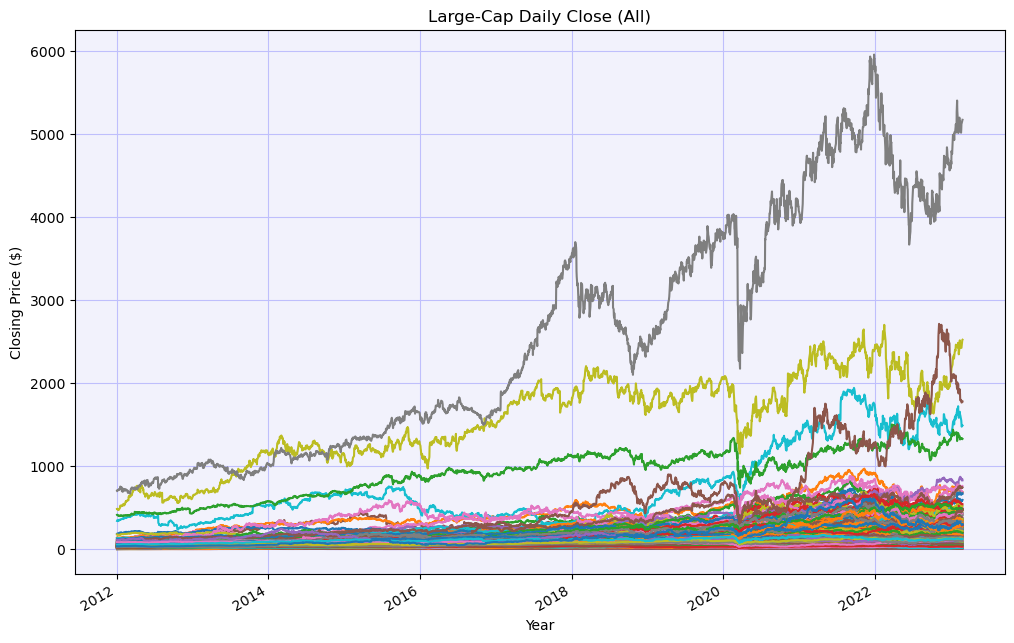

In [23]:
# Visualise the large-cap data
fig, ax = plt.subplots(figsize=(12,8))
large_close.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Large-Cap Daily Close (All)')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

The code works like we want it to, so let's finish collecting the data for mid- and small-caps.

---

* **Mid-cap Daily Close Prices**

In [24]:
# Mid-Caps
mcND = pd.read_csv('Mid_All_NSDQ.csv')
mcNE = pd.read_csv('Mid_All_NYSE.csv')
mc_df = pd.concat([mcNE,mcND], axis=0)

In [101]:
# Drop duplicates w/ pandas method if exist
mc_dup_stocks = mc_df.drop_duplicates(inplace=True)
print(mc_dup_stocks)

None


In [102]:
# Create a list of all the ticker symbols for mid-caps
mc_tickers = [symbol for symbol in mc_df['Symbol']]

# Print the no. of entries in the list
print(len(mc_tickers))

782


In [37]:
# Run multithreading operation for mid-caps
del temp_list  # clear the temp_list variable
temp_list = []  # initiate the temp variable

start = time.time()
executor = cf.ThreadPoolExecutor(16)
futures = [executor.submit(collect_data(mc_tickers))]  # pass the mc_tickers
cf.wait(futures)
end = time.time()
print('  time taken {:.2f} s'.format(end-start))

[*********************100%***********************]  1 of 1 completed
  time taken 167.65 s


In [39]:
# Assign the current data to a new variable for future use
mc_temp = temp_list

In [72]:
# Check the no. of observations
len(mc_temp)

782

In [40]:
# Keep the close price for each mid-cap ticker by date
mc_close = pd.concat(mc_temp).pivot(columns='Ticker', values='Close')
mc_close.index = pd.to_datetime(mc_close.index)
mc_close.head()

Ticker,AAON,AAP,AAWW,AB,ABCB,ABG,ABM,ABR,ACAD,ACHC,...,XRAY,XRX,YELP,YETI,Z,ZD,ZG,ZI,ZION,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,9.160000,69.099998,38.880001,13.45,10.57,21.709999,20.879999,3.53,1.11,9.92,...,35.380001,21.607378,NaN,NaN,NaN,25.078260,7.193639,NaN,16.770000,NaN
2012-01-04 00:00:00-05:00,9.084444,70.720001,39.279999,14.10,10.36,21.500000,20.620001,3.48,1.09,9.74,...,35.369999,21.475626,NaN,NaN,NaN,24.573914,7.174930,NaN,17.139999,NaN
2012-01-05 00:00:00-05:00,9.031111,71.169998,38.700001,14.80,10.42,21.660000,20.219999,3.49,1.10,9.77,...,35.400002,21.343874,NaN,NaN,NaN,25.060869,7.171812,NaN,17.620001,NaN
2012-01-06 00:00:00-05:00,8.933333,71.500000,39.020000,14.88,10.64,21.570000,20.360001,3.60,1.15,11.36,...,35.189999,21.343874,NaN,NaN,NaN,24.765217,7.184284,NaN,17.639999,NaN
2012-01-09 00:00:00-05:00,8.911111,71.480003,39.900002,14.81,10.62,22.389999,20.320000,3.72,1.19,11.30,...,35.020000,21.317522,NaN,NaN,NaN,24.330435,7.181166,NaN,17.879999,NaN


In [43]:
# List the ticker & total NaN values in the data
mc_null = pd.DataFrame()
mc_null['NaN'] = mc_close.isnull().sum()
mc_null = mc_null.loc[mc_null['NaN'] != 0]
mc_null.reset_index(inplace=True)
mc_null

,Ticker,NaN
0,ACT,2442
1,ADT,1521
2,AFRM,2272
3,AKRO,1877
4,ALGM,2221
...,...,...
264,YELP,41
265,YETI,1715
266,Z,900
267,ZI,2118


In [44]:
# Build df of mid-cap close prices after dropping tickers w/ NaN values
mid_close = mc_close.loc[:,mc_close.notna().all(axis=0)]
mid_close

Ticker,AAON,AAP,AAWW,AB,ABCB,ABG,ABM,ABR,ACAD,ACHC,...,WU,WWD,WWE,X,XPO,XRAY,XRX,ZD,ZG,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,9.160000,69.099998,38.880001,13.450000,10.570000,21.709999,20.879999,3.53,1.110000,9.920000,...,18.549999,41.980000,9.460000,28.170000,4.094911,35.380001,21.607378,25.078260,7.193639,16.770000
2012-01-04 00:00:00-05:00,9.084444,70.720001,39.279999,14.100000,10.360000,21.500000,20.620001,3.48,1.090000,9.740000,...,18.299999,42.250000,9.340000,28.440001,4.053408,35.369999,21.475626,24.573914,7.174930,17.139999
2012-01-05 00:00:00-05:00,9.031111,71.169998,38.700001,14.800000,10.420000,21.660000,20.219999,3.49,1.100000,9.770000,...,18.389999,42.650002,9.500000,27.790001,4.056867,35.400002,21.343874,25.060869,7.171812,17.620001
2012-01-06 00:00:00-05:00,8.933333,71.500000,39.020000,14.880000,10.640000,21.570000,20.360001,3.60,1.150000,11.360000,...,18.309999,42.580002,9.640000,27.299999,4.091452,35.189999,21.343874,24.765217,7.184284,17.639999
2012-01-09 00:00:00-05:00,8.911111,71.480003,39.900002,14.810000,10.620000,22.389999,20.320000,3.72,1.190000,11.300000,...,18.370001,43.119999,9.530000,26.780001,4.046491,35.020000,21.317522,24.330435,7.181166,17.879999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22 00:00:00-05:00,78.029999,143.619995,101.820000,38.770000,47.220001,228.979996,48.200001,15.29,18.959999,80.669998,...,13.450000,99.639999,85.070000,28.389999,34.630001,35.139999,16.250000,82.150002,41.740002,49.320000
2023-02-23 00:00:00-05:00,80.370003,142.009995,101.779999,39.529999,48.290001,229.389999,48.790001,15.36,19.100000,80.489998,...,13.270000,98.029999,86.519997,28.309999,34.689999,35.220001,16.610001,81.599998,41.570000,49.360001
2023-02-24 00:00:00-05:00,81.470001,138.850006,101.750000,39.230000,48.020000,221.240005,48.820000,15.28,18.920000,80.250000,...,13.090000,97.919998,85.790001,28.270000,34.169998,34.330002,16.280001,79.769997,40.500000,50.270000


In [46]:
# Derive the trading days in a year from the mid-cap data
mc_trDays_year = pd.DataFrame(mid_close['AAON'].groupby([mid_close['AAON'].index.year]).agg('count')).reset_index()
mc_trDays_year.rename(columns={'AAON': 'Trading Days'}, inplace=True)
mc_trDays_year

,Date,Trading Days
0,2012,250
1,2013,252
2,2014,252
3,2015,252
4,2016,252
5,2017,251
6,2018,251
7,2019,252
8,2020,253
9,2021,252


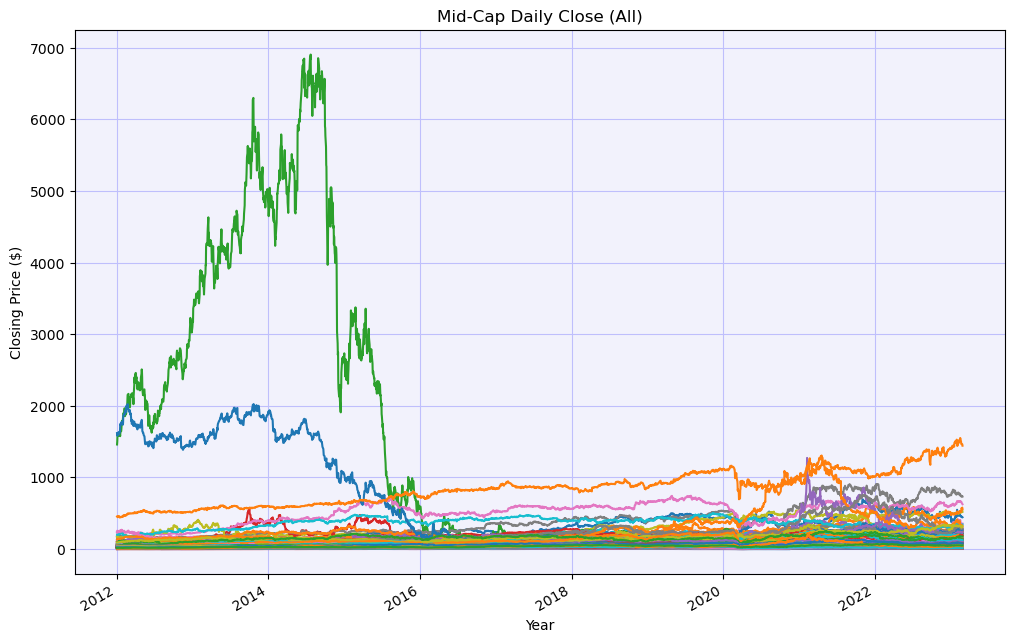

In [47]:
# Visualise the mid-cap data
fig, ax = plt.subplots(figsize=(12,8))
mid_close.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Mid-Cap Daily Close (All)')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

---

* **Small-cap Daily Close Prices**

In [ ]:
# Small-Caps
scND = pd.read_csv('Small_All_NSDQ.csv')
scNE = pd.read_csv('Small_All_NYSE.csv')
sc_df = pd.concat([scNE,scND], axis=0)

In [103]:
# Drop duplicates w/ pandas method if exist
sc_dup_stocks = sc_df.drop_duplicates(inplace=True)
print(sc_dup_stocks)

None


In [104]:
# Create a list of all the ticker symbols for small-caps
sc_tickers = [symbol for symbol in sc_df['Symbol']]

# Print the no. of entries in the list
print(len(sc_tickers))

3727


In [48]:
# Run multithreading operation for small-caps
del temp_list  # clear the temp_list variable
temp_list = []  # initiate the temp variable

start = time.time()
executor = cf.ThreadPoolExecutor(16)
futures = [executor.submit(collect_data(sc_tickers))]  # pass the sc_tickers
cf.wait(futures)
end = time.time()
print('  time taken {:.2f} s'.format(end-start))

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AACIW: Period 'max' is invalid, must be one of ['1d', '5d']

...                   ...        ...        ...        ...   
1 Failed download:
- VGASW: Period 'max' is invalid, must be one of ['1d', '5d']

...                   ...        ...        ...        ...   
1 Failed download:
- ZTAQW: Period 'max' is invalid, must be one of ['1d', '5d']
  time taken 1150.13 s


Although there are several failed downloads, this is not concerning because we have heaps of stock names from which to make our selection. Downloads may fail if the data is not available from Yahoo, but another important observation is that most of the failed downloads are of tickers which end in "W", meaning the entry represents warrants (convertible into stock).

In [54]:
# Assign the current data to a new variable for future use
sc_temp = temp_list

In [82]:
# Check the no. of observations
len(sc_temp)

3727

In [55]:
# Keep the close price for each small-cap ticker by date
sc_close = pd.concat(sc_temp).pivot(columns='Ticker', values='Close')
sc_close.index = pd.to_datetime(sc_close.index)
sc_close.head()

Ticker,AACI,AADI,AAIC,AAIN,AAME,AAOI,AAT,ABEO,ABIO,ABOS,...,ZIONO,ZIONP,ZIVO,ZNTL,ZT,ZTR,ZVSA,ZYME,ZYNE,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,NaN,NaN,21.420000,NaN,1.97,NaN,20.920000,1750.0,756.000000,NaN,...,NaN,16.639999,0.26,NaN,NaN,12.28,NaN,NaN,NaN,0.636364
2012-01-04 00:00:00-05:00,NaN,NaN,20.799999,NaN,1.96,NaN,20.250000,1750.0,748.440002,NaN,...,NaN,17.000000,0.24,NaN,NaN,12.24,NaN,NaN,NaN,0.645455
2012-01-05 00:00:00-05:00,NaN,NaN,21.020000,NaN,2.03,NaN,20.490000,1750.0,740.880005,NaN,...,NaN,16.950001,0.24,NaN,NaN,12.16,NaN,NaN,NaN,0.663636
2012-01-06 00:00:00-05:00,NaN,NaN,20.680000,NaN,1.98,NaN,20.370001,1700.0,771.119995,NaN,...,NaN,17.600000,0.23,NaN,NaN,12.20,NaN,NaN,NaN,0.672727
2012-01-09 00:00:00-05:00,NaN,NaN,20.590000,NaN,2.02,NaN,19.920000,1700.0,763.559998,NaN,...,NaN,17.600000,0.21,NaN,NaN,12.20,NaN,NaN,NaN,0.627273


In [56]:
# List the ticker & total NaN values in the small-cap data
sc_null = pd.DataFrame()
sc_null['NaN'] = sc_close.isnull().sum()
sc_null = sc_null.loc[sc_null['NaN'] != 0]
sc_null.reset_index(inplace=True)
sc_null

,Ticker,NaN
0,AACI,2481
1,AADI,1541
2,AAIN,2400
3,AAOI,435
4,ABOS,2389
...,...,...
1954,ZNTL,2076
1955,ZT,2421
1956,ZVSA,2545
1957,ZYME,1338


In [57]:
# Build df of small-cap close prices after dropping tickers w/ NaN values
small_close = sc_close.loc[:,sc_close.notna().all(axis=0)]
small_close

Ticker,AAIC,AAME,AAT,ABEO,ABIO,ABVC,ACCO,ACER,ACGN,ACHV,...,XOMA,XWEL,YELL,YORW,ZEST,ZEUS,ZIONP,ZIVO,ZTR,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,21.420000,1.97,20.920000,1750.00,756.000000,2579.617920,9.77,316.666656,157.759995,26158.00,...,25.000000,546.00,8.98,17.950001,187.50,25.549999,16.639999,0.26,12.28,0.636364
2012-01-04 00:00:00-05:00,20.799999,1.96,20.250000,1750.00,748.440002,2579.617920,9.66,313.333344,157.759995,25784.00,...,24.799999,552.00,9.30,17.660000,187.50,24.459999,17.000000,0.24,12.24,0.645455
2012-01-05 00:00:00-05:00,21.020000,2.03,20.490000,1750.00,740.880005,3582.802490,9.36,316.666656,152.320007,25388.00,...,25.000000,564.00,9.29,17.450001,200.00,24.389999,16.950001,0.24,12.16,0.663636
2012-01-06 00:00:00-05:00,20.680000,1.98,20.370001,1700.00,771.119995,3582.802490,9.33,316.666656,152.320007,25960.00,...,25.600000,564.00,9.30,17.420000,200.00,23.809999,17.600000,0.23,12.20,0.672727
2012-01-09 00:00:00-05:00,20.590000,2.02,19.920000,1700.00,763.559998,2063.694336,9.34,306.666656,160.479996,27192.00,...,27.799999,576.00,9.19,17.190001,200.00,23.500000,17.600000,0.21,12.20,0.627273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22 00:00:00-05:00,3.020000,2.40,25.740000,2.33,2.120000,0.750000,5.59,2.180000,4.850000,5.22,...,21.200001,0.45,2.57,45.490002,0.21,46.139999,21.129999,3.62,6.51,12.540000
2023-02-23 00:00:00-05:00,3.040000,2.38,25.809999,2.30,2.100000,0.730000,5.67,2.160000,5.020000,5.07,...,21.000000,0.43,2.62,45.410000,0.20,45.939999,21.250000,3.50,6.55,12.630000
2023-02-24 00:00:00-05:00,3.030000,2.40,25.469999,2.25,2.090000,0.695000,5.39,2.140000,4.510000,4.99,...,21.600000,0.43,2.59,45.049999,0.19,46.549999,21.650000,3.39,6.55,12.820000


In [58]:
# Derive the trading days in a year from the mid-cap data
sc_trDays_year = pd.DataFrame(small_close['AAIC'].groupby([small_close['AAIC'].index.year]).agg('count')).reset_index()
sc_trDays_year.rename(columns={'AAIC': 'Trading Days'}, inplace=True)
sc_trDays_year

,Date,Trading Days
0,2012,250
1,2013,252
2,2014,252
3,2015,252
4,2016,252
5,2017,251
6,2018,251
7,2019,252
8,2020,253
9,2021,252


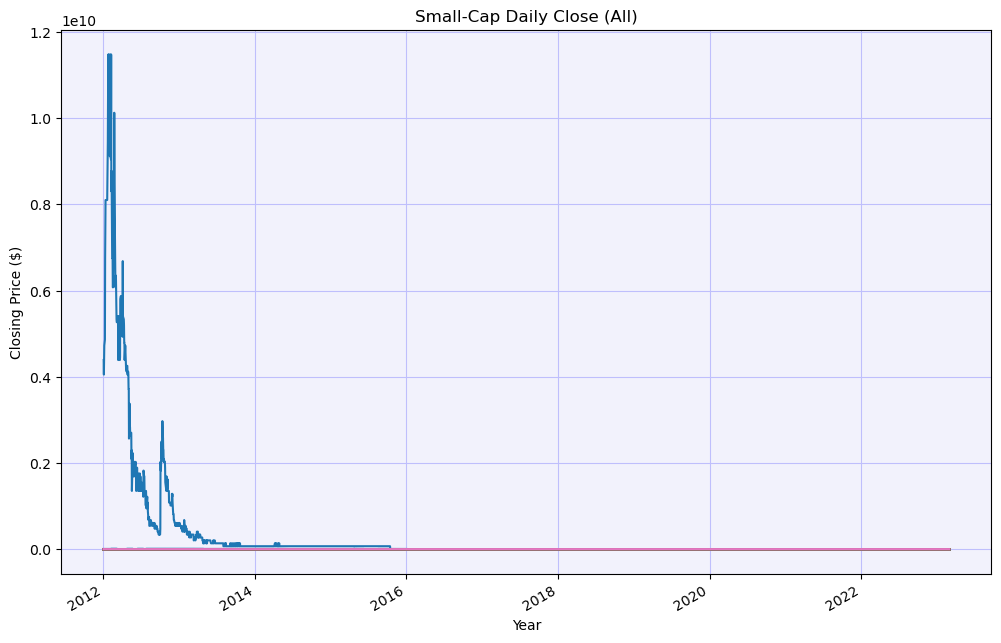

In [59]:
# Visualise the small-cap data
fig, ax = plt.subplots(figsize=(12,8))
small_close.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Small-Cap Daily Close (All)')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

One caveat to using data from Yahoo or other public APIs is the quality of financial data we seek. After observing the plots of each market cap, it's not immediately clear if closing prices reflect stock splits or not. Despite a comment found in QuantStackExchange mentioning that Yahoo's historical close prices are backwards adjusted for corporate actions, even if this is true in some way we don't know if the adjustments are splits only or including dividends. Fortunately we saved the raw data in some temp variables that we can use to go back and extract the adjusted close prices. Let's check what the large-cap set returns when we run our code for the adjusted attribute. This will help us decide which prices to use for our technical analysis and backtesting. For buy and hold strategies, one argument is to use split-adjusted data including dividend payments since these actions would affect performance when holding the stock for longer periods. On the other hand, for a short-term trading system, stops and exits based on dollar values are not appropriate for split-adjusted data

---

#### Adjusted Close Pricing

* **Large-Cap Daily Adjusted Close Prices**

In [84]:
# Keep the adjusted close price for each ticker by date
lc_adjClose = pd.concat(lc_temp).pivot(columns='Ticker', values='Adj Close')
lc_adjClose.index = pd.to_datetime(lc_adjClose.index)
lc_adjClose.head()

Ticker,A,AAL,AAPL,ABBV,ABC,ABNB,ABT,ACI,ACM,ADBE,...,XM,XOM,XYL,YUM,YUMC,ZBH,ZBRA,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,23.661139,4.826837,12.500192,NaN,31.948935,NaN,21.708191,NaN,20.583387,28.570000,...,NaN,54.496990,21.578617,33.970036,NaN,47.716305,35.720001,NaN,NaN,NaN
2012-01-04 00:00:00-05:00,23.473036,4.741990,12.567372,NaN,32.058029,NaN,21.623989,NaN,20.622972,28.280001,...,NaN,54.509674,22.291046,34.202034,NaN,47.070518,35.450001,NaN,NaN,NaN
2012-01-05 00:00:00-05:00,23.998409,5.156796,12.706895,NaN,32.301384,NaN,21.574242,NaN,20.850574,28.480000,...,NaN,54.344921,21.973454,34.463039,NaN,47.627831,35.400002,NaN,NaN,NaN
2012-01-06 00:00:00-05:00,24.257858,5.279352,12.839728,NaN,32.385303,NaN,21.379053,NaN,20.969328,28.719999,...,NaN,53.939339,21.604368,34.712429,NaN,47.751675,35.110001,NaN,NaN,NaN
2012-01-09 00:00:00-05:00,24.893488,5.392480,12.819361,NaN,32.368530,NaN,21.375216,NaN,21.018805,28.530001,...,NaN,54.180153,21.690207,34.579033,NaN,48.105534,34.950001,NaN,NaN,NaN


In [85]:
# List the ticker & total NaN values in the data
lc_adj_null = pd.DataFrame()
lc_adj_null['NaN'] = lc_adjClose.isnull().sum()
lc_adj_null = lc_adj_null.loc[lc_adj_null['NaN'] != 0]
lc_adj_null.reset_index(inplace=True)
lc_adj_null

,Ticker,NaN
0,ABBV,250
1,ABNB,2250
2,ACI,2134
3,AGR,996
4,BJ,1632
...,...,...
75,XM,2282
76,YUMC,1205
77,ZM,1834
78,ZS,1560


In [86]:
# Build df of close prices after dropping tickers w/ NaN values
large_adjClose = lc_adjClose.loc[:,lc_adjClose.notna().all(axis=0)]
large_adjClose

Ticker,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,WST,WTRG,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,23.661139,4.826837,12.500192,31.948935,21.708191,20.583387,28.570000,27.605883,36.966007,30.809999,...,17.661880,13.303112,12.364990,85.516464,19.092758,54.496990,21.578617,33.970036,47.716305,35.720001
2012-01-04 00:00:00-05:00,23.473036,4.741990,12.567372,32.058029,21.623989,20.622972,28.280001,27.567577,36.925274,30.209999,...,17.495220,13.193322,12.229044,84.045761,18.967054,54.509674,22.291046,34.202034,47.070518,35.450001
2012-01-05 00:00:00-05:00,23.998409,5.156796,12.706895,32.301384,21.574242,20.850574,28.480000,27.690163,37.196781,30.820000,...,17.513733,13.120125,12.157829,83.167892,19.050858,54.344921,21.973454,34.463039,47.627831,35.400002
2012-01-06 00:00:00-05:00,24.257858,5.279352,12.839728,32.385303,21.379053,20.969328,28.719999,27.506283,37.251080,30.959999,...,17.569290,13.083527,12.313208,80.241570,18.994993,53.939339,21.604368,34.712429,47.751675,35.110001
2012-01-09 00:00:00-05:00,24.893488,5.392480,12.819361,32.368530,21.375216,21.018805,28.530001,28.042614,37.108551,31.080000,...,17.606335,12.961535,12.164305,80.016479,19.008955,54.180153,21.690207,34.579033,48.105534,34.950001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22 00:00:00-05:00,142.080002,15.560000,148.910004,160.130005,102.690002,88.150002,348.720001,182.908752,221.674591,216.699997,...,305.549988,45.369999,30.655039,107.669998,66.690002,109.730003,103.019997,129.309998,123.620003,304.869995
2023-02-23 00:00:00-05:00,143.199997,15.870000,149.399994,159.500000,102.550003,88.070000,347.019989,184.789993,221.525436,221.160004,...,312.029999,45.139999,30.873718,105.839996,66.330002,110.739998,103.309998,128.669998,123.169998,301.000000
2023-02-24 00:00:00-05:00,141.199997,15.560000,146.710007,158.570007,100.459999,87.139999,320.540009,182.940002,220.332199,192.529999,...,310.250000,44.400002,30.684858,105.529999,65.809998,110.750000,102.400002,126.830002,122.699997,291.920013


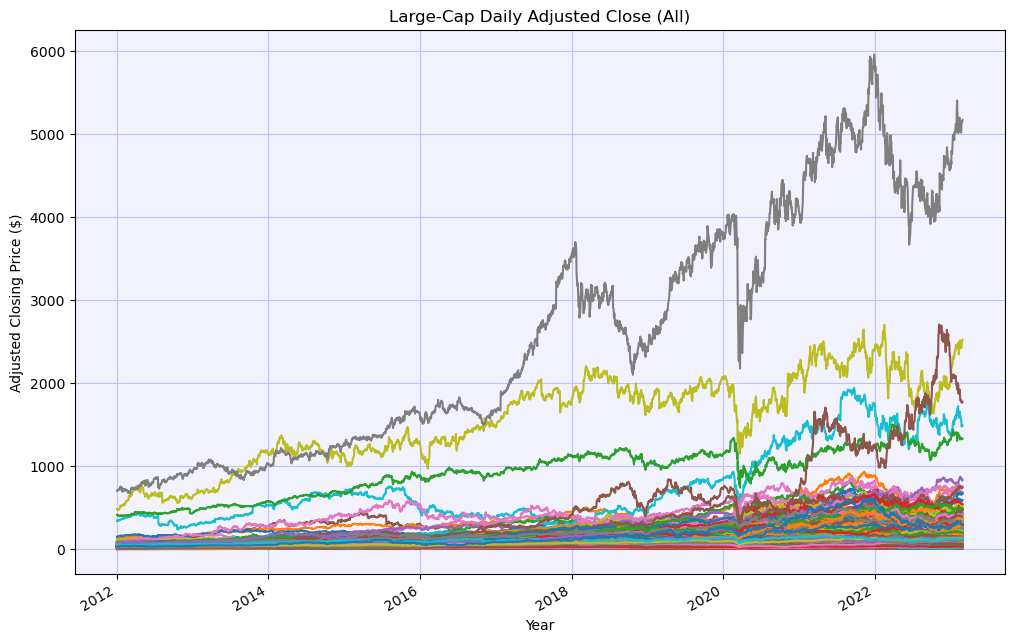

In [87]:
# Visualise the large-cap data
fig, ax = plt.subplots(figsize=(12,8))
large_adjClose.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Large-Cap Daily Adjusted Close (All)')
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

In [88]:
# Export current df to .csv file
large_adjClose.to_csv('Large_Cap_AdjClose.csv', index=True)

---

* **Mid-cap Daily Adjusted Close Prices**

In [90]:
# Keep the adjusted close price for each mid-cap ticker by date
mc_adjClose = pd.concat(mc_temp).pivot(columns='Ticker', values='Close')
mc_adjClose.index = pd.to_datetime(mc_adjClose.index)
mc_adjClose.head()

Ticker,AAON,AAP,AAWW,AB,ABCB,ABG,ABM,ABR,ACAD,ACHC,...,XRAY,XRX,YELP,YETI,Z,ZD,ZG,ZI,ZION,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,9.160000,69.099998,38.880001,13.45,10.57,21.709999,20.879999,3.53,1.11,9.92,...,35.380001,21.607378,NaN,NaN,NaN,25.078260,7.193639,NaN,16.770000,NaN
2012-01-04 00:00:00-05:00,9.084444,70.720001,39.279999,14.10,10.36,21.500000,20.620001,3.48,1.09,9.74,...,35.369999,21.475626,NaN,NaN,NaN,24.573914,7.174930,NaN,17.139999,NaN
2012-01-05 00:00:00-05:00,9.031111,71.169998,38.700001,14.80,10.42,21.660000,20.219999,3.49,1.10,9.77,...,35.400002,21.343874,NaN,NaN,NaN,25.060869,7.171812,NaN,17.620001,NaN
2012-01-06 00:00:00-05:00,8.933333,71.500000,39.020000,14.88,10.64,21.570000,20.360001,3.60,1.15,11.36,...,35.189999,21.343874,NaN,NaN,NaN,24.765217,7.184284,NaN,17.639999,NaN
2012-01-09 00:00:00-05:00,8.911111,71.480003,39.900002,14.81,10.62,22.389999,20.320000,3.72,1.19,11.30,...,35.020000,21.317522,NaN,NaN,NaN,24.330435,7.181166,NaN,17.879999,NaN


In [91]:
# List the ticker & total NaN values in the data
mc_adj_null = pd.DataFrame()
mc_adj_null['NaN'] = mc_adjClose.isnull().sum()
mc_adj_null = mc_adj_null.loc[mc_adj_null['NaN'] != 0]
mc_adj_null.reset_index(inplace=True)
mc_adj_null

,Ticker,NaN
0,ACT,2442
1,ADT,1521
2,AFRM,2272
3,AKRO,1877
4,ALGM,2221
...,...,...
264,YELP,41
265,YETI,1715
266,Z,900
267,ZI,2118


In [92]:
# Build df of mid-cap adjusted close prices after dropping tickers w/ NaN values
mid_adjClose = mc_adjClose.loc[:,mc_adjClose.notna().all(axis=0)]
mid_adjClose

Ticker,AAON,AAP,AAWW,AB,ABCB,ABG,ABM,ABR,ACAD,ACHC,...,WU,WWD,WWE,X,XPO,XRAY,XRX,ZD,ZG,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,9.160000,69.099998,38.880001,13.450000,10.570000,21.709999,20.879999,3.53,1.110000,9.920000,...,18.549999,41.980000,9.460000,28.170000,4.094911,35.380001,21.607378,25.078260,7.193639,16.770000
2012-01-04 00:00:00-05:00,9.084444,70.720001,39.279999,14.100000,10.360000,21.500000,20.620001,3.48,1.090000,9.740000,...,18.299999,42.250000,9.340000,28.440001,4.053408,35.369999,21.475626,24.573914,7.174930,17.139999
2012-01-05 00:00:00-05:00,9.031111,71.169998,38.700001,14.800000,10.420000,21.660000,20.219999,3.49,1.100000,9.770000,...,18.389999,42.650002,9.500000,27.790001,4.056867,35.400002,21.343874,25.060869,7.171812,17.620001
2012-01-06 00:00:00-05:00,8.933333,71.500000,39.020000,14.880000,10.640000,21.570000,20.360001,3.60,1.150000,11.360000,...,18.309999,42.580002,9.640000,27.299999,4.091452,35.189999,21.343874,24.765217,7.184284,17.639999
2012-01-09 00:00:00-05:00,8.911111,71.480003,39.900002,14.810000,10.620000,22.389999,20.320000,3.72,1.190000,11.300000,...,18.370001,43.119999,9.530000,26.780001,4.046491,35.020000,21.317522,24.330435,7.181166,17.879999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22 00:00:00-05:00,78.029999,143.619995,101.820000,38.770000,47.220001,228.979996,48.200001,15.29,18.959999,80.669998,...,13.450000,99.639999,85.070000,28.389999,34.630001,35.139999,16.250000,82.150002,41.740002,49.320000
2023-02-23 00:00:00-05:00,80.370003,142.009995,101.779999,39.529999,48.290001,229.389999,48.790001,15.36,19.100000,80.489998,...,13.270000,98.029999,86.519997,28.309999,34.689999,35.220001,16.610001,81.599998,41.570000,49.360001
2023-02-24 00:00:00-05:00,81.470001,138.850006,101.750000,39.230000,48.020000,221.240005,48.820000,15.28,18.920000,80.250000,...,13.090000,97.919998,85.790001,28.270000,34.169998,34.330002,16.280001,79.769997,40.500000,50.270000


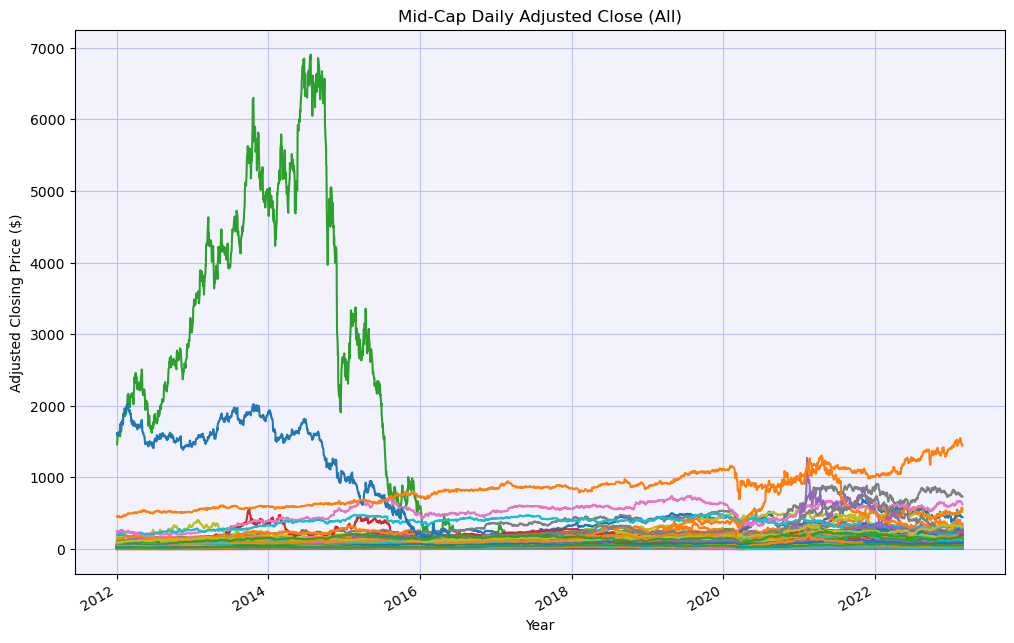

In [93]:
# Visualise the mid-cap data
fig, ax = plt.subplots(figsize=(12,8))
mid_adjClose.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Mid-Cap Daily Adjusted Close (All)')
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

In [94]:
# Export current df to .csv file
mid_adjClose.to_csv('Mid_Cap_AdjClose.csv', index=True)

---

* **Small-cap Daily Adjusted Close Prices**

In [96]:
# Keep the adjusted close price for each small-cap ticker by date
sc_adjClose = pd.concat(sc_temp).pivot(columns='Ticker', values='Close')
sc_adjClose.index = pd.to_datetime(sc_adjClose.index)
sc_adjClose.head()

Ticker,AACI,AADI,AAIC,AAIN,AAME,AAOI,AAT,ABEO,ABIO,ABOS,...,ZIONO,ZIONP,ZIVO,ZNTL,ZT,ZTR,ZVSA,ZYME,ZYNE,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,NaN,NaN,21.420000,NaN,1.97,NaN,20.920000,1750.0,756.000000,NaN,...,NaN,16.639999,0.26,NaN,NaN,12.28,NaN,NaN,NaN,0.636364
2012-01-04 00:00:00-05:00,NaN,NaN,20.799999,NaN,1.96,NaN,20.250000,1750.0,748.440002,NaN,...,NaN,17.000000,0.24,NaN,NaN,12.24,NaN,NaN,NaN,0.645455
2012-01-05 00:00:00-05:00,NaN,NaN,21.020000,NaN,2.03,NaN,20.490000,1750.0,740.880005,NaN,...,NaN,16.950001,0.24,NaN,NaN,12.16,NaN,NaN,NaN,0.663636
2012-01-06 00:00:00-05:00,NaN,NaN,20.680000,NaN,1.98,NaN,20.370001,1700.0,771.119995,NaN,...,NaN,17.600000,0.23,NaN,NaN,12.20,NaN,NaN,NaN,0.672727
2012-01-09 00:00:00-05:00,NaN,NaN,20.590000,NaN,2.02,NaN,19.920000,1700.0,763.559998,NaN,...,NaN,17.600000,0.21,NaN,NaN,12.20,NaN,NaN,NaN,0.627273


In [97]:
# List the ticker & total NaN values in the small-cap data
sc_adj_null = pd.DataFrame()
sc_adj_null['NaN'] = sc_adjClose.isnull().sum()
sc_adj_null = sc_adj_null.loc[sc_adj_null['NaN'] != 0]
sc_adj_null.reset_index(inplace=True)
sc_adj_null

,Ticker,NaN
0,AACI,2481
1,AADI,1541
2,AAIN,2400
3,AAOI,435
4,ABOS,2389
...,...,...
1954,ZNTL,2076
1955,ZT,2421
1956,ZVSA,2545
1957,ZYME,1338


In [98]:
# Build df of small-cap close prices after dropping tickers w/ NaN values
small_adjClose = sc_adjClose.loc[:,sc_adjClose.notna().all(axis=0)]
small_adjClose

Ticker,AAIC,AAME,AAT,ABEO,ABIO,ABVC,ACCO,ACER,ACGN,ACHV,...,XOMA,XWEL,YELL,YORW,ZEST,ZEUS,ZIONP,ZIVO,ZTR,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 00:00:00-05:00,21.420000,1.97,20.920000,1750.00,756.000000,2579.617920,9.77,316.666656,157.759995,26158.00,...,25.000000,546.00,8.98,17.950001,187.50,25.549999,16.639999,0.26,12.28,0.636364
2012-01-04 00:00:00-05:00,20.799999,1.96,20.250000,1750.00,748.440002,2579.617920,9.66,313.333344,157.759995,25784.00,...,24.799999,552.00,9.30,17.660000,187.50,24.459999,17.000000,0.24,12.24,0.645455
2012-01-05 00:00:00-05:00,21.020000,2.03,20.490000,1750.00,740.880005,3582.802490,9.36,316.666656,152.320007,25388.00,...,25.000000,564.00,9.29,17.450001,200.00,24.389999,16.950001,0.24,12.16,0.663636
2012-01-06 00:00:00-05:00,20.680000,1.98,20.370001,1700.00,771.119995,3582.802490,9.33,316.666656,152.320007,25960.00,...,25.600000,564.00,9.30,17.420000,200.00,23.809999,17.600000,0.23,12.20,0.672727
2012-01-09 00:00:00-05:00,20.590000,2.02,19.920000,1700.00,763.559998,2063.694336,9.34,306.666656,160.479996,27192.00,...,27.799999,576.00,9.19,17.190001,200.00,23.500000,17.600000,0.21,12.20,0.627273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22 00:00:00-05:00,3.020000,2.40,25.740000,2.33,2.120000,0.750000,5.59,2.180000,4.850000,5.22,...,21.200001,0.45,2.57,45.490002,0.21,46.139999,21.129999,3.62,6.51,12.540000
2023-02-23 00:00:00-05:00,3.040000,2.38,25.809999,2.30,2.100000,0.730000,5.67,2.160000,5.020000,5.07,...,21.000000,0.43,2.62,45.410000,0.20,45.939999,21.250000,3.50,6.55,12.630000
2023-02-24 00:00:00-05:00,3.030000,2.40,25.469999,2.25,2.090000,0.695000,5.39,2.140000,4.510000,4.99,...,21.600000,0.43,2.59,45.049999,0.19,46.549999,21.650000,3.39,6.55,12.820000


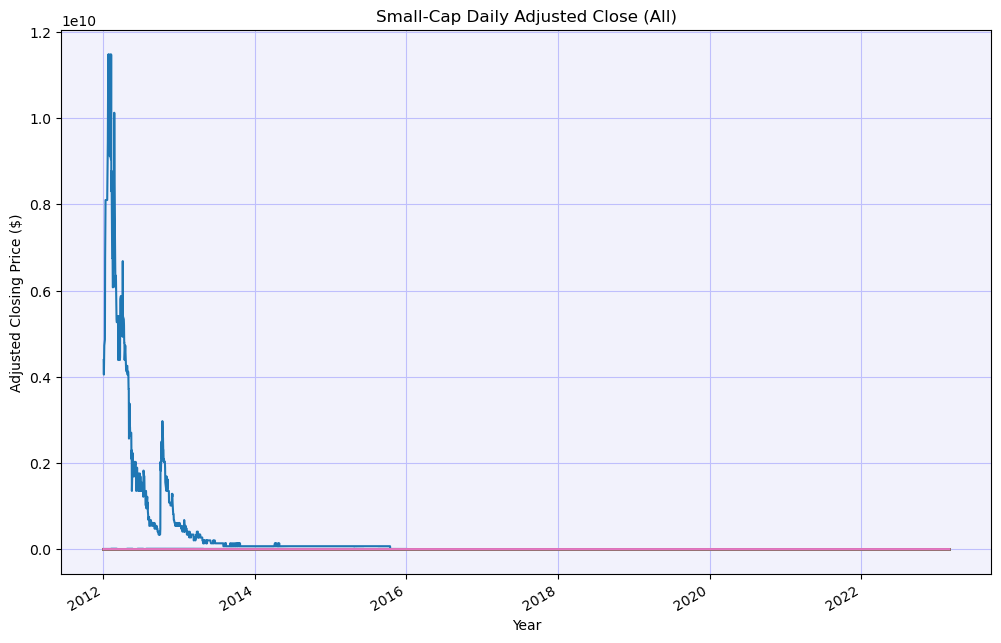

In [100]:
# Visualise the small-cap data
fig, ax = plt.subplots(figsize=(12,8))
small_adjClose.plot(ax = plt.gca(),grid = True)
ax.get_legend().remove()
ax.set_title('Small-Cap Daily Adjusted Close (All)')
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Price ($)')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

In [105]:
# Export current df to .csv file
small_adjClose.to_csv('Small_Cap_AdjClose.csv', index=True)

In [126]:
# Convert the raw data to single dataframes & save to .csv
lcRaw = pd.concat(lc_temp)
mcRaw = pd.concat(mc_temp)
scRaw = pd.concat(sc_temp)

lcRaw.to_csv('LargeCap_Raw.csv', index=True)
mcRaw.to_csv('MidCap_Raw.csv', index=True)
scRaw.to_csv('SmallCap_Raw.csv', index=True)

---
---

### Step 2: Statistical Performance Metrics & Analysis

A diversified portfolio should have low correlation between asset classes. Since the portfolios we build will likely be heavily concentrated with stocks, our aim is to ensure low correlation between stocks grouped by market cap. In this section, we calculate expected returns, covariances, and other metrics required for mean-variance portfolio optimisation. The limitation of this approach is that it is naturally a single-period optimiser. As new information becomes available, such a portfolio requires a rebalancing of positions at the end of the chosen time horizon.

The calculations performed below take advantage of Python's `PyPorfolioOpt` library. When calculating expected returns, we appy the Capital Asset Pricing Model. The CAPM states that expected returns in excess of the risk-free rate depend on an investment's relative volatility compared with the broader market. The Efficient Frontier algorithm's documentation states the risk-free rate should correspond to the frequency of expected returns; thus, we use the 52-week U.S. T-bill coupon rate of 4.30% as of 18 March, 2023.

* **S&P 500 Index Portfolio Benchmark**

In [5]:
# Retrieve S&P500 data from Yahoo Finance
sp_raw = yf.download('^GSPC', start='2012-01-01', end='2023-03-01', group_by='Ticker')
sp_raw.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2807 entries, 2012-01-03 00:00:00-05:00 to 2023-02-28 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2807 non-null   float64
 1   High       2807 non-null   float64
 2   Low        2807 non-null   float64
 3   Close      2807 non-null   float64
 4   Adj Close  2807 non-null   float64
 5   Volume     2807 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 153.5 KB


In [6]:
# Build a dataframe of Daily Close prices
sp_data = pd.DataFrame(sp_raw['Adj Close'])
sp_data.index = pd.to_datetime(sp_data.index)
sp500 = sp_data.rename(columns={'Adj Close': 'SP500'})
sp500.tail()

,SP500
Date,
2023-02-22 00:00:00-05:00,3991.050049
2023-02-23 00:00:00-05:00,4012.320068
2023-02-24 00:00:00-05:00,3970.040039
2023-02-27 00:00:00-05:00,3982.239990
2023-02-28 00:00:00-05:00,3970.149902


In [7]:
# Compute the SP500 index expected returns
sp_exp_returns = expected_returns.capm_return(sp500, risk_free_rate=0.0430)
sp_exp_returns

SP500    0.107232
Name: mkt, dtype: float64

* **Stock Expected Returns**

In [2]:
large_adjClose = pd.read_csv('Large_Cap_AdjClose.csv', parse_dates=['Date'], index_col=['Date'])
mid_adjClose = pd.read_csv('Mid_Cap_AdjClose.csv', parse_dates=['Date'], index_col=['Date'])
small_adjClose = pd.read_csv('Small_Cap_AdjClose.csv', parse_dates=['Date'], index_col=['Date'])

In [93]:
# Large-cap expected returns
lc_exp_returns = expected_returns.capm_return(large_adjClose, market_prices=sp500, risk_free_rate=0.0430)
# Mid-cap expected returns
mc_exp_returns = expected_returns.capm_return(mid_adjClose, market_prices=sp500, risk_free_rate=0.0430)
# Small-cap expected returns
sc_exp_returns = expected_returns.capm_return(small_adjClose, market_prices=sp500, risk_free_rate=0.0430)

# Combine all mkt-cap returns into one dataframe
returns_list = [lc_exp_returns, mc_exp_returns, sc_exp_returns]
returns = pd.concat(returns_list, axis=0)
exp_returns = pd.Series(returns).rename('Annual Returns')
exp_returns

A        0.112232
AAL      0.130189
AAPL     0.118581
ABC      0.091338
ABT      0.100117
           ...   
ZEUS     0.117244
ZIONP    0.060813
ZIVO     0.074597
ZTR      0.087119
ZYXI     0.087586
Name: Annual Returns, Length: 2371, dtype: float64

**Risk Models**

In [191]:
# Merge Adj Close prices into single dataframe for covariance matrix
price_list = [large_adjClose, mid_adjClose, small_adjClose]
prices = pd.concat(price_list, axis=1)

The first risk model we show estimates covariance given that returns are less than the benchmark. Note that the covariance matrix produced will be quite large and anomalies can happen with rounding errors causing negative eigenvalues. An important step before moving forward in optimising portfolios to form an Efficient Frontier is checking that the covariance matrix is positive semi-definite (PSD). `PyPortfolioOpt`'s `risk_models` has a built-in method to check and correct if a covariance matrix is not PSD, so everything should work as expected.


In [192]:
# Develop a semi-covariance matrix of the combined securities
benchmark = 1.043**(1/252) - 1
semicov = risk_models.semicovariance(prices, benchmark=benchmark)
semicov

,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,XOMA,XWEL,YELL,YORW,ZEST,ZEUS,ZIONP,ZIVO,ZTR,ZYXI
A,0.033604,0.031054,0.020960,0.014869,0.018939,0.025191,0.025046,0.023516,0.017387,0.029298,...,0.037327,0.046831,0.043268,0.016121,0.037407,0.030115,0.010792,0.036889,0.014265,0.029970
AAL,0.031054,0.113178,0.032425,0.025327,0.024068,0.042140,0.033596,0.037654,0.028562,0.043692,...,0.060866,0.081888,0.084234,0.027435,0.065910,0.056679,0.022481,0.059544,0.027683,0.057241
AAPL,0.020960,0.032425,0.040023,0.015451,0.017313,0.023554,0.027565,0.026070,0.018753,0.029518,...,0.038169,0.047207,0.046357,0.017067,0.041683,0.029867,0.010667,0.043297,0.015151,0.032774
ABC,0.014869,0.025327,0.015451,0.031608,0.014247,0.019382,0.015455,0.016671,0.014916,0.018238,...,0.030123,0.036932,0.039203,0.014020,0.032938,0.024616,0.010128,0.033782,0.012084,0.029156
ABT,0.018939,0.024068,0.017313,0.014247,0.025602,0.018583,0.019776,0.018161,0.015670,0.021397,...,0.030852,0.036394,0.035170,0.013631,0.031530,0.021374,0.009002,0.031142,0.011040,0.025504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEUS,0.030115,0.056679,0.029867,0.024616,0.021374,0.042880,0.029597,0.033707,0.024171,0.038511,...,0.070638,0.086258,0.083436,0.030446,0.074469,0.136549,0.016770,0.082266,0.020865,0.058613
ZIONP,0.010792,0.022481,0.010667,0.010128,0.009002,0.016730,0.011963,0.013210,0.010957,0.015383,...,0.021728,0.033146,0.027076,0.011378,0.024054,0.016770,0.029780,0.028526,0.014610,0.023384
ZIVO,0.036889,0.059544,0.043297,0.033782,0.031142,0.047989,0.042269,0.040918,0.029377,0.047260,...,0.092466,0.138187,0.103177,0.040677,0.190139,0.082266,0.028526,0.645665,0.026049,0.103708
ZTR,0.014265,0.027683,0.015151,0.012084,0.011040,0.022023,0.017073,0.018253,0.015296,0.019632,...,0.025507,0.038275,0.032077,0.015544,0.025142,0.020865,0.014610,0.026049,0.026491,0.023640


The second risk model incorporates calculating the Oracle Approximating Shrinkage (OAS) estimate. This method was introduced by Chen *et al.* in 2010 for estimating covariance in the sense of MMSE for Gaussian samples with improvements over the Ledoit-Wolf method.

In [23]:
# Develop an oracle-approximating cov matrix of the combined securities
orac_cov = risk_models.risk_matrix(prices, method='oracle_approximating')
orac_cov = risk_models.fix_nonpositive_semidefinite(orac_cov)
orac_cov

,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,XOMA,XWEL,YELL,YORW,ZEST,ZEUS,ZIONP,ZIVO,ZTR,ZYXI
A,1.014017,0.040882,0.035750,0.023547,0.033894,0.039639,0.043855,0.042561,0.031465,0.051867,...,0.044271,0.035242,0.060127,0.024820,0.000508,0.039711,0.010327,0.024199,0.020482,0.019033
AAL,0.040882,1.206181,0.040438,0.029786,0.027428,0.059197,0.038220,0.051290,0.041057,0.058923,...,0.060861,0.111372,0.118748,0.023350,0.002614,0.070348,0.017195,-0.011839,0.033036,0.028899
AAPL,0.035750,0.040438,1.030402,0.020813,0.028810,0.032621,0.047947,0.045561,0.031534,0.050541,...,0.043418,0.045481,0.056691,0.022128,0.013044,0.032094,0.005807,-0.004122,0.021521,0.020890
ABC,0.023547,0.029786,0.020813,1.010137,0.023751,0.029963,0.020756,0.024884,0.025419,0.026156,...,0.036200,0.003637,0.040435,0.022032,0.006015,0.026623,0.006593,-0.002347,0.015079,0.020403
ABT,0.033894,0.027428,0.028810,0.023751,0.997259,0.026069,0.034016,0.030761,0.027848,0.036231,...,0.037266,0.018169,0.039803,0.022343,0.009930,0.018120,0.004850,0.033742,0.014955,0.014598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEUS,0.039711,0.070348,0.032094,0.026623,0.018120,0.068708,0.030638,0.047156,0.030228,0.047727,...,0.064691,0.055660,0.110664,0.036047,0.003141,1.250870,0.010772,-0.046077,0.023847,0.010585
ZIONP,0.010327,0.017195,0.005807,0.006593,0.004850,0.014398,0.007807,0.011185,0.008844,0.013050,...,0.012123,0.027267,0.021416,0.009466,-0.004401,0.010772,1.006705,-0.018579,0.015705,0.008931
ZIVO,0.024199,-0.011839,-0.004122,-0.002347,0.033742,-0.007091,0.049625,0.046940,-0.007954,0.007486,...,-0.083861,-0.058636,-0.015204,0.019919,0.154132,-0.046077,-0.018579,105.861074,0.005621,0.043073
ZTR,0.020482,0.033036,0.021521,0.015079,0.014955,0.030846,0.022941,0.025485,0.021807,0.027154,...,0.024808,0.038267,0.035656,0.018355,0.013646,0.023847,0.015705,0.005621,0.986599,0.015892


---
---

### Step 3: Optimisation & Portfolio Allocation

**Adding objectives and constraints**

To consider building portfolios constrained to a total allocation in market cap, we can hack `PyPortfolioOpt`'s `add_sector_constraints` to set upper and lower bounds on the ratio of companies during optimisation. We will need dictionaries of all the tickers for each market cap that we'll use for mapping the constraints.

In [129]:
# Create a dictionary of all the large-caps ticker symbols
lc_names = large_adjClose.columns.values.tolist()
lc_names = pd.Series(lc_names).to_frame().set_axis(['Ticker'], axis=1)
lc_names['Mkt Cap'] = 'Large'
lc_names.set_index('Ticker', inplace=True)
lc_names = lc_names.to_dict()['Mkt Cap']

# Create a dictionary of all the mid-caps ticker symbols
mc_names = mid_adjClose.columns.values.tolist()
mc_names = pd.Series(mc_names).to_frame().set_axis(['Ticker'], axis=1)
mc_names['Mkt Cap'] = 'Mid'
mc_names.set_index('Ticker', inplace=True)
mc_names = mc_names.to_dict()['Mkt Cap']

# Create a dictionary of all the small-caps ticker symbols
sc_names = small_adjClose.columns.values.tolist()
sc_names = pd.Series(sc_names).to_frame().set_axis(['Ticker'], axis=1)
sc_names['Mkt Cap'] = 'Small'
sc_names.set_index('Ticker', inplace=True)
sc_names = sc_names.to_dict()['Mkt Cap']

# Combine mkt-cap dictionaries into a super-dictionary for mapping
mktcap_mapper = {**lc_names, **mc_names, **sc_names}
sector_mapper = mktcap_mapper

In [353]:
# Set the upper & lower mkt-cap constraints for standard portfolio models
# Conservative Portfolio
con_lb = {'Large': 0.10, 'Mid': 0.075, 'Small': 0.075}
con_ub = {'Large': 0.15, 'Mid': 0.10, 'Small': 0.10}

# Moderate Portfolio
mod_lb = {'Large': 0.2, 'Mid': 0.16, 'Small': 0.065}
mod_ub = {'Large': 0.2, 'Mid': 0.185, 'Small': 0.09}

# Aggressive Portfolio
agg_lb = {'Large': 0.25, 'Mid': 0.2, 'Small': 0.15}
agg_ub = {'Large': 0.26, 'Mid': 0.22, 'Small': 0.17}

**Note: we have borrowed ranges of investments in equities given a portfolio style from investopedia.com, but different or custom `PyPortfolio` algorithms will need to be considered to make up the percentage of allocations that should be made to fixed-income securities and other assets. This will be interesting future work.**

---

**Investor Profiles: Risk-Aversion**

Our objective function will be to maximise utility, which is a function of risk-aversion score. This method allows us to develop an optimal portfolio based on an investor's risk-aversion score rather than a target return. The set of customer profiles with the scores we will use are in the project repository. We can import them from the URL next.

Generally, the higher an investor's risk-aversion score, the less risk one is willing to take. An aversion score of zero is considered risk-neutral. The disconnect between reality and the simulations in our project happens here. This occurs because our portfolio considerations are currently only comprised of stocks. An investor who is very risk-averse will prefer a portfolio offering more of a risk-free return, such as government bonds and CDs.

In [542]:
# Import customer risk profiles & extract risk-aversion scores
risk_profiles = pd.read_csv("https://raw.githubusercontent.com/JasonBenichou/indeng243/main/Risk_Aversion_Data.csv")
risk_profiles = risk_profiles['RiskAversion']
ra_scores = risk_profiles.rename('Risk-Aversion')
ra_scores

0        5.021125
1        6.658645
2        3.347183
3        3.180899
4        5.075350
           ...   
50395    2.621720
50396    6.021187
50397    4.996553
50398    2.111006
50399    3.180899
Name: Risk-Aversion, Length: 50400, dtype: float64

**Optimisation & Performance**

In [27]:
# Set the Efficient Frontier using semicovariance matrix
ef_semi = EfficientFrontier(exp_returns, semicov)
ef_semi.max_quadratic_utility(risk_aversion=ra_scores[0])
w_semi = ef_semi.clean_weights(cutoff=0.001)

In [28]:
# Analyse the ef_semi portfolio's performance
print(ef_semi.portfolio_performance(verbose=True, risk_free_rate=0.043))

Expected annual return: 134.2%
Annual volatility: 51.8%
Sharpe Ratio: 2.51
(1.3417705407584104, 0.5175296070199334, 2.509557952127725)


Observe the exaggerated returns and impressive sharpe ratio under the semi-covariance model. Next, let's see if there's any improvement with the OAS model.

In [29]:
# Set the Efficient Frontier using oracle approximating matrix
ef_orac = EfficientFrontier(exp_returns, orac_cov)
ef_orac.add_objective(objective_functions.L2_reg, gamma=0.2)
ef_orac.max_quadratic_utility(risk_aversion=ra_scores[0])
w_orac = ef_orac.clean_weights(cutoff=0.001)

In [31]:
# Analyse the ef_orac portfolio's performance
print(ef_orac.portfolio_performance(verbose=True, risk_free_rate=0.043))

Expected annual return: 7.6%
Annual volatility: 10.1%
Sharpe Ratio: 0.33
(0.07619747336798796, 0.10126396566573934, 0.3278310616193819)


Although the sharpe ratio is nothing to brag about, the annualised portfolio returns and volatility appear more realistic now. Recall that our objective function is maximising utility based on a moderate risk-aversion score of 5.02, rather than maximising sharpe ratio or expected returns, so these values make more sense than our previous attempt.

In [77]:
# Backup the covariance matrix to .csv
orac_cov.to_csv('Orac_Cov_Matrix.csv', index=True)

**Post-processing Weights**

Consider a total portfolio value of $20,000. First, we need to convert the continuous weight allocations to discrete quantities of shares that we could purchase on the market. We show the semi-covariance model stock allocations for visual comparison.

In [79]:
# Get the most recent stock prices
latest_prices = prices.iloc[-1,:]

# Generate discrete allocation values from the continuous weights
da_semi = discrete_allocation.DiscreteAllocation(w_semi, latest_prices=latest_prices, total_portfolio_value=20000)
allocation_semi, remaining_semi = da_semi.greedy_portfolio()

# Pass the allocation dictionary to pandas series
stocks_test = pd.Series(allocation_semi, name='Shares')
stocks_test.index.name = 'Ticker'
print(stocks_test)

# Display the remaining funds after allocation
print('Leftover Funds: $' f'{remaining_semi:.2f}')

Ticker
NCPL     4067
GJO       166
GDL       395
MOBQ    11952
BTCS     1933
EGF       139
ADX        66
Name: Shares, dtype: int64
Leftover Funds: $4.73


In [73]:
# Generate discrete allocation values from the continuous weights
da_orac = discrete_allocation.DiscreteAllocation(w_orac, latest_prices=latest_prices, total_portfolio_value=20000)
allocation_orac, remaining_orac = da_orac.greedy_portfolio()

# Pass the allocation dictionary to pandas series
stocks_to_buy = pd.Series(allocation_orac, name='Shares')
stocks_to_buy.index.name = 'Ticker'
print(stocks_to_buy)

# Display the remaining funds after allocation
print('Leftover Funds: $' f'{remaining_orac:.2f}')

Ticker
BMRA     41
GJR       2
BANFP     2
GJO       2
GJS       2
         ..
PZC       2
AWRE     12
FRA       1
NMZ       1
KEQU      1
Name: Shares, Length: 332, dtype: int64
Leftover Funds: $6.96


---
---

#### Visualisation

In [75]:
# ef_plot = EfficientFrontier(exp_returns, orac_cov)
# ef_plot.add_objective(objective_functions.L2_reg, gamma=0.2)
#
# fig, ax = plt.subplots(figsize=(8,6))
# plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)
#
# # Find the tangency portfolio
# ef_max_quad.max_quadratic_utility()
# ret_tangent, std_tangent, _ = ef_max_quad.portfolio_performance()
# ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Utility")
#
# # Generate random portfolios
# n_samples = 10000
# w = np.random.dirichlet(np.ones(ef_plot.n_assets), n_samples)
# rets = w.dot(ef_plot.expected_returns)
# stds = np.sqrt(np.diag(w @ ef_plot.cov_matrix @ w.T))
# sharpes = rets / stds
# ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
#
# # Output
# ax.set_title("Efficient Frontier with Random Portfolios")
# ax.legend()
# plt.tight_layout()
# plt.savefig("ef_scatter.png", dpi=200)
# plt.show()

There was a problem with plotting. Could this have something to do with `PyPortfolioOpt`? Errors are occurring when attempting to converge during optimisation. It's possible this could be happening because of calculations in the `risk_models` methods, but finding another way to sort and organise our data is a good idea. Let's check if the Ledoit-Wolf Shrinkage method helps us to return something useful.

In [82]:
ledoit = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
ledoit

,A,AAL,AAPL,ABC,ABT,ACM,ADBE,ADI,ADP,ADSK,...,XOMA,XWEL,YELL,YORW,ZEST,ZEUS,ZIONP,ZIVO,ZTR,ZYXI
A,950.229185,0.000016,0.000014,9.288103e-06,0.000013,0.000016,0.000017,0.000017,0.000012,0.000020,...,0.000017,0.000014,0.000024,0.000010,2.004922e-07,0.000016,0.000004,9.545342e-06,0.000008,0.000008
AAL,0.000016,950.229261,0.000016,1.174903e-05,0.000011,0.000023,0.000015,0.000020,0.000016,0.000023,...,0.000024,0.000044,0.000047,0.000009,1.031186e-06,0.000028,0.000007,-4.670043e-06,0.000013,0.000011
AAPL,0.000014,0.000016,950.229192,8.209869e-06,0.000011,0.000013,0.000019,0.000018,0.000012,0.000020,...,0.000017,0.000018,0.000022,0.000009,5.145057e-06,0.000013,0.000002,-1.625769e-06,0.000008,0.000008
ABC,0.000009,0.000012,0.000008,9.502292e+02,0.000009,0.000012,0.000008,0.000010,0.000010,0.000010,...,0.000014,0.000001,0.000016,0.000009,2.372500e-06,0.000011,0.000003,-9.258060e-07,0.000006,0.000008
ABT,0.000013,0.000011,0.000011,9.368771e-06,950.229179,0.000010,0.000013,0.000012,0.000011,0.000014,...,0.000015,0.000007,0.000016,0.000009,3.917052e-06,0.000007,0.000002,1.330946e-05,0.000006,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEUS,0.000016,0.000028,0.000013,1.050132e-05,0.000007,0.000027,0.000012,0.000019,0.000012,0.000019,...,0.000026,0.000022,0.000044,0.000014,1.239088e-06,950.229279,0.000004,-1.817497e-05,0.000009,0.000004
ZIONP,0.000004,0.000007,0.000002,2.600463e-06,0.000002,0.000006,0.000003,0.000004,0.000003,0.000005,...,0.000005,0.000011,0.000008,0.000004,-1.735952e-06,0.000004,950.229182,-7.328577e-06,0.000006,0.000004
ZIVO,0.000010,-0.000005,-0.000002,-9.258060e-07,0.000013,-0.000003,0.000020,0.000019,-0.000003,0.000003,...,-0.000033,-0.000023,-0.000006,0.000008,6.079738e-05,-0.000018,-0.000007,9.502705e+02,0.000002,0.000017
ZTR,0.000008,0.000013,0.000008,5.947901e-06,0.000006,0.000012,0.000009,0.000010,0.000009,0.000011,...,0.000010,0.000015,0.000014,0.000007,5.382745e-06,0.000009,0.000006,2.217238e-06,950.229174,0.000006


In [83]:
ef_ledw = EfficientFrontier(exp_returns, ledoit)
ef_ledw.add_objective(objective_functions.L2_reg, gamma=0.2)
ef_ledw.max_quadratic_utility(risk_aversion=ra_scores[0])
w_ledw = ef_ledw.clean_weights(cutoff=0.001)

# Analyse the ef_semi portfolio's performance
print(ef_ledw.portfolio_performance(verbose=True, risk_free_rate=0.043))

ArpackNoConvergence: ARPACK error -1: No convergence (23711 iterations, 0/1 eigenvectors converged)

There's a problem with convergence using the Ledoit Wolf Shrinkage method. In the previous example we used 2,371 stocks. Maybe we can test with a smaller sample and improve our results. What if, we calculate the performance of each stock in a market cap and compare it with the S&P 500, for now? That's precisely what the CAPM does and gives back the annualised returns, so it's already done for us. Let's take the 300 best performers by expected CAPM returns to construct a covariance matrix and build another Efficient Frontier.

In [655]:
def get_CAPMReturns(small_adjClose,
                     mid_adjClose,
                     large_adjClose,
                     location=int(),
                     market_prices=None,
                     risk_free_rate=0.02
                     ):
    # Large-caps with highest CAPM returns
    lc_sorted_returns = expected_returns.capm_return(large_adjClose, market_prices, risk_free_rate)
    lc_sorted_returns = lc_sorted_returns.sort_values(ascending=False).reset_index()
    lc_sorted_returns.columns = ['Ticker', 'Annual E[Returns]']
    lc_sorted_returns = lc_sorted_returns.loc[:location]

    # Mid-caps
    mc_sorted_returns = expected_returns.capm_return(mid_adjClose, market_prices, risk_free_rate)
    mc_sorted_returns = mc_sorted_returns.sort_values(ascending=False).reset_index()
    mc_sorted_returns.columns = ['Ticker', 'Annual E[Returns]']
    mc_sorted_returns = mc_sorted_returns.loc[:location]

    # Small-caps
    sc_sorted_returns = expected_returns.capm_return(small_adjClose, market_prices, risk_free_rate)
    sc_sorted_returns = sc_sorted_returns.sort_values(ascending=False).reset_index()
    sc_sorted_returns.columns = ['Ticker', 'Annual E[Returns]']
    sc_sorted_returns = sc_sorted_returns.loc[:location]

    return sc_sorted_returns, mc_sorted_returns, lc_sorted_returns

Now, let's get the names for these best stock picks to use for filtering the price data from our larger sets.

In [615]:
def get_Dictionary(sc_sorted_returns, mc_sorted_returns, lc_sorted_returns):
    # Create a dictionary of all the large-caps ticker symbols
    lcs_names = lc_sorted_returns['Ticker'].values.tolist()
    lcs_names = pd.Series(lcs_names).to_frame().set_axis(['Ticker'], axis=1)
    lcs_names['Mkt Cap'] = 'Large'
    lcs_names.set_index('Ticker', inplace=True)
    lcs_names = lcs_names.to_dict()['Mkt Cap']
    lcs_names = dict(sorted(lcs_names.items()))

    # Mid-caps
    mcs_names = mc_sorted_returns['Ticker'].values.tolist()
    mcs_names = pd.Series(mcs_names).to_frame().set_axis(['Ticker'], axis=1)
    mcs_names['Mkt Cap'] = 'Mid'
    mcs_names.set_index('Ticker', inplace=True)
    mcs_names = mcs_names.to_dict()['Mkt Cap']
    mcs_names = dict(sorted(mcs_names.items()))

    # Small-caps
    scs_names = sc_sorted_returns['Ticker'].values.tolist()
    scs_names = pd.Series(scs_names).to_frame().set_axis(['Ticker'], axis=1)
    scs_names['Mkt Cap'] = 'Small'
    scs_names.set_index('Ticker', inplace=True)
    scs_names = scs_names.to_dict()['Mkt Cap']
    scs_names = dict(sorted(scs_names.items()))

    return scs_names, mcs_names, lcs_names

To compute risk models we could use expected returns, but the recommendation is to input prices. For that, we need to retrieve the historical adjusted closing prices from the master list for only the tickers we are considering.

In [185]:
# Filter the adjusted close price dataframes and keep only the columns if ticker
# exists in the dictionary of names
lc_prices = large_adjClose.drop([col for col in large_adjClose.columns if col not in lcs_names], axis=1)
mc_prices = mid_adjClose.drop([col for col in mid_adjClose.columns if col not in mcs_names], axis=1)
sc_prices = small_adjClose.drop([col for col in small_adjClose.columns if col not in scs_names], axis=1)

The idea here is to compute the correlation between stocks grouped by market cap and select the ones least correlated. First, to compute the correlations we need the daily returns data. We'll use the `PyPortfolioOpt` built-in `returns_from_prices` method for this.

In [579]:
def get_DailyReturns(sc_prices, mc_prices, lc_prices):
    # Create set of large-cap/mid-cap returns
    set_lcmc = [lc_prices, mc_prices]
    set_lcmc = pd.concat(set_lcmc, axis=1)
    set_lcmc_returns = expected_returns.returns_from_prices(set_lcmc)

    # Create set of mid-cap/small-cap returns
    set_mcsc = [mc_prices, sc_prices]
    set_mcsc = pd.concat(set_mcsc, axis=1)
    set_mcsc_returns = expected_returns.returns_from_prices(set_mcsc)

    # Create set of small-cap/large-cap returns
    set_sclc = [sc_prices, lc_prices]
    set_sclc = pd.concat(set_sclc, axis=1)
    set_sclc_returns = expected_returns.returns_from_prices(set_sclc)

    return set_sclc_returns, set_mcsc_returns, set_lcmc_returns

Now that the correlations have been calculated and ordered, we'll select all the stocks with a correlation less than 0.10, combine the sets, and then remove the duplicate entries. The outputs have been suppressed for ease of readability.

In [ ]:
def get_LowCorrelatedSets(list=[set_sclc_returns, set_mcsc_returns, set_lcmc_returns], abs_value=float):
    # Create set of large-cap/mid-cap correlated pairs
    set_lcmc_corr = set_lcmc_returns.corr()
    set_lcmc_corr['Ticker 1'] = set_lcmc_corr.index
    set_lcmc_corr = set_lcmc_corr.melt(id_vars='Ticker 1', var_name='Ticker 2').reset_index(drop=True)
    set_lcmc_corr = set_lcmc_corr[set_lcmc_corr['Ticker 1'] < set_lcmc_corr['Ticker 2']].dropna()
    set_lcmc_corr['Abs Value'] = np.abs(set_lcmc_corr['value'])
    set_lcmc_corr = set_lcmc_corr.sort_values('Abs Value').drop(columns='value')

    # Create set of mid-cap/small-cap correlated pairs
    set_mcsc_corr = set_mcsc_returns.corr()
    set_mcsc_corr['Ticker 1'] = set_mcsc_corr.index
    set_mcsc_corr = set_mcsc_corr.melt(id_vars='Ticker 1', var_name='Ticker 2').reset_index(drop=True)
    set_mcsc_corr = set_mcsc_corr[set_mcsc_corr['Ticker 1'] < set_mcsc_corr['Ticker 2']].dropna()
    set_mcsc_corr['Abs Value'] = np.abs(set_mcsc_corr['value'])
    set_mcsc_corr = set_mcsc_corr.sort_values('Abs Value').drop(columns='value')

    # Create set of small-cap/large-cap correlated pairs
    set_sclc_corr = set_sclc_returns.corr()
    set_sclc_corr['Ticker 1'] = set_sclc_corr.index
    set_sclc_corr = set_sclc_corr.melt(id_vars='Ticker 1', var_name='Ticker 2').reset_index(drop=True)
    set_sclc_corr = set_sclc_corr[set_sclc_corr['Ticker 1'] < set_sclc_corr['Ticker 2']].dropna()
    set_sclc_corr['Abs Value'] = np.abs(set_sclc_corr['value'])
    set_sclc_corr = set_sclc_corr.sort_values('Abs Value').drop(columns='value')

    # Keep the names whose correlation < abs_value
    lcmc_pairs = set_lcmc_corr[set_lcmc_corr['Abs Value'] < abs_value]
    mcsc_pairs = set_mcsc_corr[set_mcsc_corr['Abs Value'] < abs_value]
    sclc_pairs = set_sclc_corr[set_sclc_corr['Abs Value'] < abs_value]

    # Large-cap/mid-cap
    lcmc_1 = lcmc_pairs['Ticker 1'].drop_duplicates()
    lcmc_2 = lcmc_pairs['Ticker 2'].drop_duplicates()
    lcmc_list = [lcmc_1, lcmc_2]
    lcmc_set = pd.concat(lcmc_list, axis=0)
    lcmc_set = pd.Series(lcmc_set).rename('Ticker').sort_values().reset_index(drop=True)
    lcmc_set = lcmc_set.values.tolist()

    # Mid-cap/small-cap
    mcsc_1 = mcsc_pairs['Ticker 1'].drop_duplicates()
    mcsc_2 = mcsc_pairs['Ticker 2'].drop_duplicates()
    mcsc_list = [mcsc_1, mcsc_2]
    mcsc_set = pd.concat(mcsc_list, axis=0)
    mcsc_set = pd.Series(mcsc_set).rename('Ticker').sort_values().reset_index(drop=True)
    mcsc_set = mcsc_set.values.tolist()

    # Small-cap/large-cap
    sclc_1 = sclc_pairs['Ticker 1'].drop_duplicates()
    sclc_2 = sclc_pairs['Ticker 2'].drop_duplicates()
    sclc_list = [sclc_1, sclc_2]
    sclc_set = pd.concat(sclc_list, axis=0)
    sclc_set = pd.Series(sclc_set).rename('Ticker').sort_values().reset_index(drop=True)
    sclc_set = sclc_set.values.tolist()

    scs_names = sc_sorted_returns['Ticker'].values.tolist()
    scs_names = pd.Series(scs_names).to_frame().set_axis(['Ticker'], axis=1)
    scs_names['Mkt Cap'] = 'Small'
    scs_names.set_index('Ticker', inplace=True)
    scs_names = scs_names.to_dict()['Mkt Cap']
    scs_names = dict(sorted(scs_names.items()))

    # Combine all the sets into one master set
    complete_set = [*lcmc_set, *mcsc_set, *sclc_set]
    complete_set = pd.Series(complete_set).to_frame().set_axis(['Ticker'], axis=1)
    complete_set = complete_set.sort_values('Ticker').drop_duplicates()
    complete_set.reset_index(inplace=True, drop=True)
    complete_set = complete_set.pivot_table(index='Ticker')
    complete_set = complete_set.T.to_dict()

    return complete_set

In [402]:
# Keep the names whose correlation < 0.10
lcmc_pairs = set_lcmc_corr[set_lcmc_corr['Abs Value'] < 0.10]
mcsc_pairs = set_mcsc_corr[set_mcsc_corr['Abs Value'] < 0.10]
sclc_pairs = set_sclc_corr[set_sclc_corr['Abs Value'] < 0.10]

In [403]:
# Large-cap/mid-cap
lcmc_1 = lcmc_pairs['Ticker 1'].drop_duplicates()
lcmc_2 = lcmc_pairs['Ticker 2'].drop_duplicates()
lcmc_list = [lcmc_1, lcmc_2]
lcmc_set = pd.concat(lcmc_list, axis=0)
lcmc_set = pd.Series(lcmc_set).rename('Ticker').sort_values().reset_index(drop=True)
lcmc_set = lcmc_set.values.tolist()

# Mid-cap/small-cap
mcsc_1 = mcsc_pairs['Ticker 1'].drop_duplicates()
mcsc_2 = mcsc_pairs['Ticker 2'].drop_duplicates()
mcsc_list = [mcsc_1, mcsc_2]
mcsc_set = pd.concat(mcsc_list, axis=0)
mcsc_set = pd.Series(mcsc_set).rename('Ticker').sort_values().reset_index(drop=True)
mcsc_set = mcsc_set.values.tolist()

# Small-cap/large-cap
sclc_1 = sclc_pairs['Ticker 1'].drop_duplicates()
sclc_2 = sclc_pairs['Ticker 2'].drop_duplicates()
sclc_list = [sclc_1, sclc_2]
sclc_set = pd.concat(sclc_list, axis=0)
sclc_set = pd.Series(sclc_set).rename('Ticker').sort_values().reset_index(drop=True)
sclc_set = sclc_set.values.tolist()

All that's left is to combine all the stock picks into a master set of tickers that we can query from the original dataset of daily adjusted close prices and compute the expected returns.

In [644]:
# Combine all the sets into one master set
complete_set = [*lcmc_set, *mcsc_set, *sclc_set]
complete_set = pd.Series(complete_set).to_frame().set_axis(['Ticker'], axis=1)
complete_set = complete_set.sort_values('Ticker').drop_duplicates()
complete_set.reset_index(inplace=True, drop=True)
complete_set = complete_set.pivot_table(index='Ticker')
complete_set = complete_set.T.to_dict()

In [541]:
# Project the intersection of prices and complete_set
all_prices = prices.drop([col for col in prices.columns if col not in complete_set], axis=1)

# Compute the expected returns
all_returns = expected_returns.capm_return(all_prices, market_prices=sp500, risk_free_rate=0.0430)
all_returns

A       0.112232
AAL     0.130189
AAPL    0.118581
ABT     0.100117
ACM     0.119781
          ...   
WW      0.135139
WWW     0.116906
XOMA    0.123245
YELL    0.160888
ZEUS    0.117244
Name: mkt, Length: 900, dtype: float64

The dataset `all_prices` contains 900 stocks having market cap correlations of less than 0.10. Now, let's run the portfolio allocation process again to see if we've made any progress.

In [553]:
# Get the covariance matrix using Ledoit-Wolf Shrinkage
cov_matrix_ledw = risk_models.CovarianceShrinkage(all_prices).ledoit_wolf()
cov_matrix_ledw

,A,AAL,AAPL,ABT,ACM,ADBE,ADI,ADP,ADSK,AES,...,WGO,WNC,WRLD,WT,WTI,WW,WWW,XOMA,YELL,ZEUS
A,765.376443,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
AAL,0.000000,765.376443,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
AAPL,0.000000,0.000000,765.376443,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ABT,0.000000,0.000000,0.000000,765.376443,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ACM,0.000000,0.000000,0.000000,0.000000,765.376443,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WW,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,765.376443,0.000000,0.000000,0.000000,0.000000
WWW,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,765.376443,0.000000,0.000000,0.000000
XOMA,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,765.376443,0.000000,0.000000
YELL,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,765.376443,0.000000


In [557]:
# Set the Efficient Frontier using Ledoit-Wolf Shrinkage
ledw_ef = EfficientFrontier(all_returns, cov_matrix_ledw)
ledw_ef.add_objective(objective_functions.L2_reg, gamma=0.2)
ledw_ef.max_quadratic_utility(risk_aversion=ra_scores[0])
ledw_w = ledw_ef.clean_weights(cutoff=0.001)

In [558]:
# Analyse the ef_orac portfolio's performance
print(ledw_ef.portfolio_performance(verbose=True, risk_free_rate=0.043))

Expected annual return: 13.4%
Annual volatility: 92.3%
Sharpe Ratio: 0.10
(0.13419261611779776, 0.9226720230754147, 0.09883535409888994)


Although we converged successfully, the Ledoit-Wolf model is definitely not a good choice for this dataset. Due to time constraints, we can try one last time.

---

**Start with a smaller dataset**

In [656]:
# Get the top 100 stocks based on CAPM returns
x, y, z = get_CAPMReturns(small_adjClose, mid_adjClose, large_adjClose, location=99, market_prices=sp500, risk_free_rate=0.0430)

In [657]:
# Write a dictionary w/ the top names and get their daily adj. close prices
a, b, c = get_Dictionary(x, y, z)

sc_prices2 = small_adjClose.drop([col for col in small_adjClose.columns if col not in a], axis=1)
mc_prices2 = mid_adjClose.drop([col for col in mid_adjClose.columns if col not in b], axis=1)
lc_prices2 = large_adjClose.drop([col for col in large_adjClose.columns if col not in c], axis=1)

In [658]:
# Retrieve the daily returns and the stocks w/ correlation<0.075
set_sclc_returns2, set_mcsc_returns2, set_lcmc_returns2 = get_DailyReturns(sc_prices2, mc_prices2, lc_prices2)
dreturns = list([set_sclc_returns2, set_mcsc_returns2, set_lcmc_returns2])
last_set = get_LowCorrelatedSets(dreturns, 0.075)

Fetch the prices and expected returns:

In [652]:
# Project the intersection of prices and complete_set
all_prices2 = prices.drop([col for col in prices.columns if col not in last_set], axis=1)

# Compute the expected returns
all_returns2 = expected_returns.capm_return(all_prices2, market_prices=sp500, risk_free_rate=0.0430)
all_returns2

A       0.112232
AAL     0.130189
AAPL    0.118581
ABT     0.100117
ACM     0.119781
          ...   
WW      0.135139
WWW     0.116906
XOMA    0.123245
YELL    0.160888
ZEUS    0.117244
Name: mkt, Length: 900, dtype: float64

After running the project and just prior to this point, most of the data wrangling was handled directly without using defined functions. Then we went back and updated some work defining processes as functions. Note that the new list of low-correlated returns still has 900 entries. This will need to be addressed before pursuing future work. In the meantime, we'll try computing the exponentially-weighted covariance matrix.

In [653]:
# Exp-weighted covariance
cov_exp = risk_models.exp_cov(all_prices2)
cov_exp

,A,AAL,AAPL,ABT,ACM,ADBE,ADI,ADP,ADSK,AES,...,WGO,WNC,WRLD,WT,WTI,WW,WWW,XOMA,YELL,ZEUS
A,0.096249,0.059458,0.059267,0.049206,0.041240,0.074260,0.061409,0.045913,0.088092,0.048006,...,0.057052,0.051645,0.090810,0.038119,0.058208,0.121542,0.081544,0.065712,0.114959,0.055376
AAL,0.059458,0.219617,0.076664,0.044468,0.052396,0.084534,0.078507,0.046450,0.103832,0.059121,...,0.103258,0.093598,0.179310,0.068611,0.095691,0.177233,0.122314,0.065482,0.198314,0.111427
AAPL,0.059267,0.076664,0.109150,0.045711,0.042143,0.091483,0.081594,0.055996,0.103066,0.052634,...,0.079099,0.062039,0.130833,0.046281,0.065235,0.134844,0.088466,0.034300,0.172301,0.069948
ABT,0.049206,0.044468,0.045711,0.056089,0.029319,0.053127,0.045563,0.039458,0.061705,0.039539,...,0.047751,0.040602,0.073370,0.033171,0.025315,0.084910,0.052351,0.031507,0.094689,0.038981
ACM,0.041240,0.052396,0.042143,0.029319,0.059721,0.044465,0.044460,0.036185,0.054746,0.050981,...,0.038543,0.047896,0.050506,0.036606,0.065128,0.069314,0.055925,0.027714,0.081401,0.060018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WW,0.121542,0.177233,0.134844,0.084910,0.069314,0.166676,0.140295,0.075648,0.189682,0.103275,...,0.186527,0.130997,0.303968,0.110339,0.185034,0.678798,0.254191,0.010739,0.335099,0.134490
WWW,0.081544,0.122314,0.088466,0.052351,0.055925,0.098917,0.097682,0.048403,0.137064,0.070364,...,0.119363,0.098320,0.177573,0.065565,0.182014,0.254191,0.416530,0.041909,0.257134,0.106799
XOMA,0.065712,0.065482,0.034300,0.031507,0.027714,0.018001,0.035944,0.028989,0.006486,-0.004070,...,0.014309,0.045905,0.019635,0.013793,0.037061,0.010739,0.041909,0.553481,0.025120,0.074639
YELL,0.114959,0.198314,0.172301,0.094689,0.081401,0.220379,0.180342,0.099089,0.241520,0.125864,...,0.196573,0.171154,0.305102,0.108654,0.112863,0.335099,0.257134,0.025120,0.947227,0.140346


In [654]:
# Set the Efficient Frontier using the exponentially-weighted covariance
ef_exp = EfficientFrontier(all_returns2, cov_exp)
ef_exp.add_objective(objective_functions.L2_reg, gamma=0.2)
ef_exp.max_quadratic_utility(risk_aversion=ra_scores[0])
w_exp = ledw_ef.clean_weights(cutoff=0.001)

ArpackNoConvergence: ARPACK error -1: No convergence (9001 iterations, 0/1 eigenvectors converged)

No luck with exponentially-weighted covariance on this dataset! Bummer!

---
---

### Conclusion

The simulations and analysis indicate that for a customer with a risk-aversion score of 5.02, our models could produce an optimal portfolio of pure stocks with an annual expected return of 7.6%. In particular, this portfolio would contain 332 stocks that have been selected from large, mid, and small market capitalisation groups for minimal diversification. For a customer with $20,000 to invest, all the required shares could be purchased with only 6.96 remaining, which our customer could take to Starbucks for a coffee while waiting on the recommendation. It is important to mention that this portfolio's sharpe ratio is bad, but considering the alternatives and an investor with the example risk-aversion score it offers the most realistic risk and return. Such a portfolio would require monitoring and rebalancing over time. We were not able to allocate total market cap weights this time, but this should be pursued in future work along with selecting fewer stocks and working on custom objective functions.